In [6]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 30.1 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_event_info(events):
    data = []
    for event in events:
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        # Informações dos múons
        muon_info = {}
        if len(muon_pairs) >= 1:
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            muon_info['muon_mass'] = invariant_mass(muon1, muon2)
            muon_info['muon1_pt'] = muon1.pt()
            muon_info['muon2_pt'] = muon2.pt()
            muon_info['muon1_energy'] = muon1.e()
            muon_info['muon2_energy'] = muon2.e()
            muon_info['di_muon_energy'] = muon1.e() + muon2.e()
            muon_info['di_muon_pt'] = muon1.pt() + muon2.pt()
        else:
            muon_info['muon_mass'] = 0.0
            muon_info['muon1_pt'] = 0.0
            muon_info['muon2_pt'] = 0.0
            muon_info['muon1_energy'] = 0.0
            muon_info['muon2_energy'] = 0.0
            muon_info['di_muon_energy'] = 0.0
            muon_info['di_muon_pt'] = 0.0
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Informações dos jatos
        jet_info = {}
        if len(jets) >= 2:
            b_jets = []
            b_tagged_distances = []
            for jet in jets:
                is_b_tagged_flag, b_tag_distance = is_b_tagged(jet, particles_no_muons)
                if is_b_tagged_flag:
                    b_jets.append(jet)
                    b_tagged_distances.append(b_tag_distance)
            
            if len(b_jets) >= 2:
                b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
                b_jets_selected = b_jets_sorted[:2]
                jet_info['jet_mass'] = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                jet_info['jet1_pt'] = b_jets_selected[0].pt()
                jet_info['jet2_pt'] = b_jets_selected[1].pt()
                jet_info['jet1_energy'] = b_jets_selected[0].e()
                jet_info['jet2_energy'] = b_jets_selected[1].e()
                jet_info['di_jet_energy'] = b_jets_selected[0].e() + b_jets_selected[1].e()
                jet_info['di_jet_pt'] = b_jets_selected[0].pt() + b_jets_selected[1].pt()
                jet_info['delta_r'] = delta_r(b_jets_selected[0], b_jets_selected[1])
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = b_tagged_distances[0]  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = b_tagged_distances[1]  # Distância de decaimento do segundo jato b-tagged
            else:
                jet_info['jet_mass'] = 0.0
                jet_info['jet1_pt'] = 0.0
                jet_info['jet2_pt'] = 0.0
                jet_info['jet1_energy'] = 0.0
                jet_info['jet2_energy'] = 0.0
                jet_info['di_jet_energy'] = 0.0
                jet_info['di_jet_pt'] = 0.0
                jet_info['delta_r'] = 0.0
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        else:
            jet_info['jet_mass'] = 0.0
            jet_info['jet1_pt'] = 0.0
            jet_info['jet2_pt'] = 0.0
            jet_info['jet1_energy'] = 0.0
            jet_info['jet2_energy'] = 0.0
            jet_info['di_jet_energy'] = 0.0
            jet_info['di_jet_pt'] = 0.0
            jet_info['delta_r'] = 0.0
            jet_info['num_jets'] = len(jets)
            jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
            jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        
        # Combinar informações
        event_info = {**muon_info, **jet_info}
        data.append(event_info)
    
    return pd.DataFrame(data)

# Processar eventos de sinal
print("Processando eventos de sinal...")
signal_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(sinal_file)])
signal_df['label'] = [[1, 0, 0] for _ in range(len(signal_df))]  # Sinal: [1, 0, 0] para cada evento

# Processar eventos de background 1
print("\nProcessando eventos de background 1...")
background1_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file1)])
background1_df['label'] = [[0, 1, 0] for _ in range(len(background1_df))]  # Background 1: [0, 1, 0] para cada evento

# Processar eventos de background 2
print("\nProcessando eventos de background 2...")
background2_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file2)])
background2_df['label'] = [[0, 0, 1] for _ in range(len(background2_df))]  # Background 2: [0, 0, 1] para cada evento


2025-03-28 21:20:47.725225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-28 21:20:47.726109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 21:20:47.734197: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 21:20:47.743070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743207647.754419   38003 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743207647.75

Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos lidos: 500
Uso de memória: 1282

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Juntar todos os DataFrames e criar rótulos
df = pd.concat([signal_df, background1_df, background2_df])

# 2. Converter labels one-hot para números inteiros (0, 1, 2)
labels = np.argmax(np.array(df['label'].tolist()), axis=1)  # Converte [[1,0,0], [0,1,0], ...] para [0, 1, ...]

# 3. Remover coluna 'label' original
features = df.drop(columns=['label'])

# 4. Dividir em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=42,
    stratify=labels  # Mantém proporção das classes
)

# 5. Normalizar os dados (importante para XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# 1. Definir o modelo
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Para classificação multiclasse
    num_class=3,                # Número de classes
    n_estimators=150,           # Número de árvores
    max_depth=5,                # Profundidade máxima
    learning_rate=0.1,          # Taxa de aprendizado
    subsample=0.9,              # Fração de amostras por árvore (0-1)
    colsample_bytree=0.9,       # Fração de features por árvore (0-1)
    random_state=42,
    n_jobs=-1                   # Usar todos os núcleos do CPU
)

# 2. Treinar o modelo
print("Treinando o XGBoost...")
model.fit(X_train_scaled, y_train)

# 3. Fazer previsões
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)  # Probabilidades para cada classe

# 4. Avaliar
print("\nAcurácia:", accuracy_score(y_test, y_pred))

Treinando o XGBoost...

Acurácia: 0.9145



Relatório de Classificação:
                      precision    recall  f1-score   support

         Sinal (hh)       0.97      0.96      0.97      2000
    Background (ZZ)       0.93      0.85      0.89      2000
Background (jjmumu)       0.85      0.94      0.89      2000

           accuracy                           0.91      6000
          macro avg       0.92      0.91      0.91      6000
       weighted avg       0.92      0.91      0.91      6000



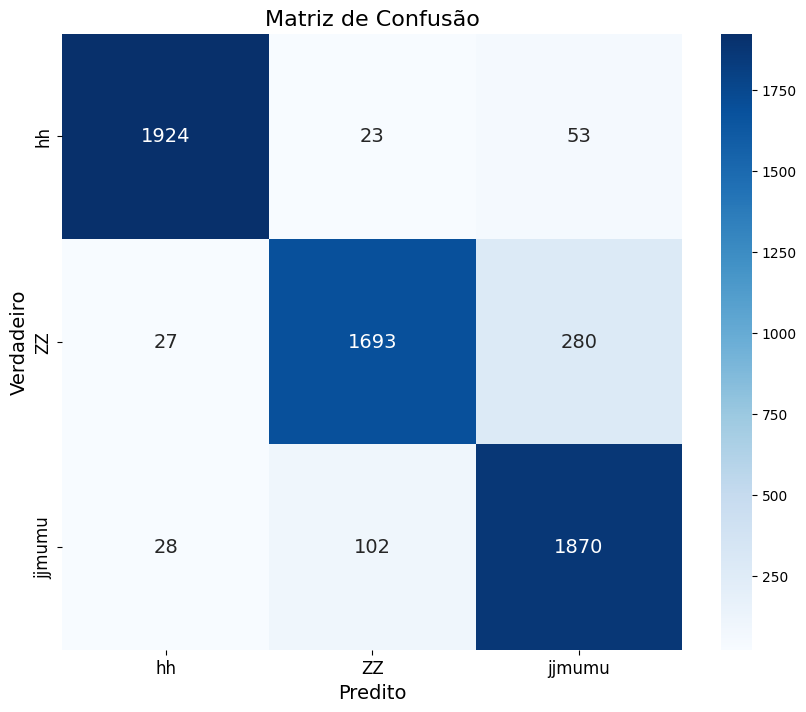

<Figure size 1200x800 with 0 Axes>

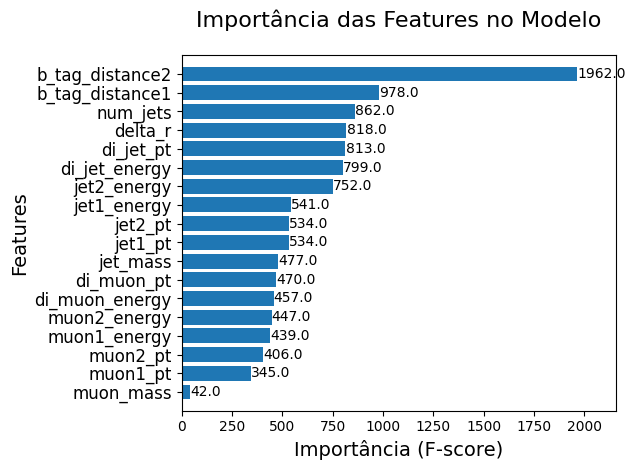

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Definir os nomes das features conforme sua estrutura original
feature_names = [
    'muon_mass', 'muon1_pt', 'muon2_pt', 'muon1_energy', 'muon2_energy',
    'di_muon_energy', 'di_muon_pt', 'jet_mass', 'jet1_pt', 'jet2_pt',
    'jet1_energy', 'jet2_energy', 'di_jet_energy', 'di_jet_pt', 'delta_r',
    'num_jets', 'b_tag_distance1', 'b_tag_distance2'
]

# 1. Relatório de classificação
print("\nRelatório de Classificação:\n", 
      classification_report(y_test, y_pred, target_names=['Sinal (hh)', 'Background (ZZ)', 'Background (jjmumu)']))

# 2. Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['hh', 'ZZ', 'jjmumu'], 
            yticklabels=['hh', 'ZZ', 'jjmumu'],
            annot_kws={"size": 14})
plt.xlabel('Predito', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=14)
plt.title('Matriz de Confusão', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 3. Importância das features com nomes personalizados
plt.figure(figsize=(12, 8))
ax = xgb.plot_importance(model, 
                        max_num_features=18, 
                        height=0.8,
                        importance_type='weight',
                        xlabel='F-score',
                        title='Importância das Features (XGBoost)',
                        grid=False)

# Ajustar os rótulos para usar os nomes corretos
ax.set_yticklabels(feature_names, fontsize=12)
ax.set_xlabel('Importância (F-score)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Importância das Features no Modelo', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from '/home/levi/miniconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

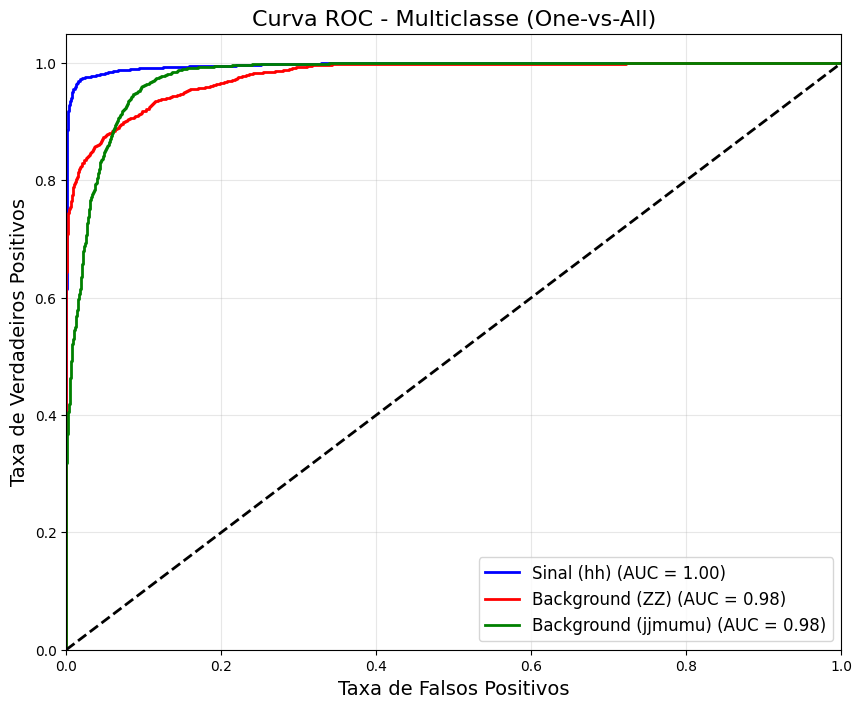

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1. Binarizar os labels para formato one-vs-all
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# 2. Obter as probabilidades previstas para cada classe
y_proba = model.predict_proba(X_test_scaled)

# 3. Calcular ROC para cada classe
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['Sinal (hh)', 'Background (ZZ)', 'Background (jjmumu)']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# 4. Configurar o gráfico
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title('Curva ROC - Multiclasse (One-vs-All)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt

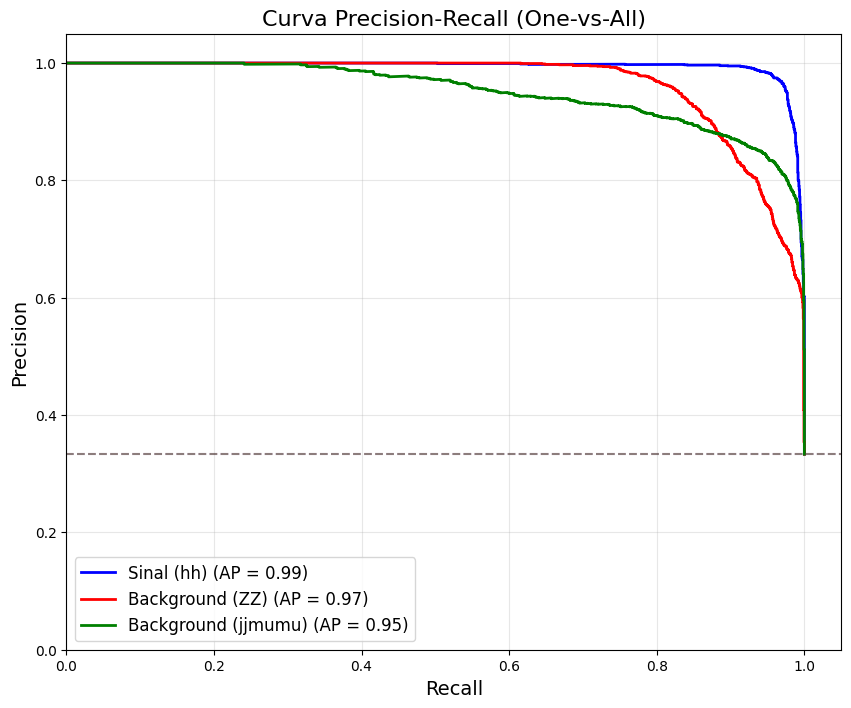


Average Precision (Macro): 0.9701


In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1. Binarizar os labels para formato one-vs-all
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# 2. Obter probabilidades previstas
y_proba = model.predict_proba(X_test_scaled)

# 3. Calcular Precision-Recall para cada classe
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['Sinal (hh)', 'Background (ZZ)', 'Background (jjmumu)']

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    
    plt.plot(recall, precision, color=colors[i], lw=2,
             label=f'{class_names[i]} (AP = {ap_score:.2f})')

# 4. Configurar o gráfico
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('Curva Precision-Recall (One-vs-All)', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.3)

# 5. Linha de baseline (proporção da classe positiva)
for i in range(n_classes):
    baseline = np.mean(y_test_bin[:, i])
    plt.axhline(y=baseline, color=colors[i], linestyle='--', alpha=0.3)

plt.show()

# 6. Average Precision (macro)
ap_macro = average_precision_score(y_test_bin, y_proba, average='macro')
print(f"\nAverage Precision (Macro): {ap_macro:.4f}")